In [1]:
import copy
from pathlib import Path
import warnings
from typing import Dict, List, Tuple, Union

import torch
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# Test Dataset

In [2]:
data = pd.read_pickle('../M5_Dataset/tft_dataset.pkl')
data["month"] = data["month"].astype(str).astype("category")

special_days = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
snap_days = ['snap_CA', 'snap_TX', 'snap_WI']

data[snap_days] = data[snap_days].astype(str).astype("category")

train_dataset = data[data.d < 1912]
test_dataset = data[data.d >= 1912]

max_prediction_length = 30
max_encoder_length = 90
training_cutoff = train_dataset["d"].max() - max_prediction_length

test_encoder = train_dataset[lambda x: x.d > x.d.max() - max_encoder_length]
test_dataset = pd.concat([test_encoder, test_dataset], ignore_index=True)
test_cutoff = test_dataset["d"].max() - max_prediction_length

In [3]:
test_dataset.keys()

Index(['store_id', 'dept_id', 'state_id', 'cat_id', 'Node', 'd', 'sold',
       'date', 'weekday', 'wday', 'month', 'event_name_1', 'event_type_1',
       'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI'],
      dtype='object')

In [4]:
test_dataset = test_dataset[['Node', 'store_id', 'dept_id', 'state_id', 'cat_id', 'd', 'sold',
       'date', 'weekday', 'wday', 'month', 'event_name_1', 'event_type_1',
       'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI']]

In [5]:
test_dataset.head()

,Node,store_id,dept_id,state_id,cat_id,d,sold,date,weekday,wday,month,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,CA_1_FOODS_1,CA_1,FOODS_1,CA,FOODS,1822,401.0,2016-01-24,Sunday,2,1,-,-,-,-,0,0,0
1,CA_1_FOODS_2,CA_1,FOODS_2,CA,FOODS,1822,621.0,2016-01-24,Sunday,2,1,-,-,-,-,0,0,0
2,CA_1_FOODS_3,CA_1,FOODS_3,CA,FOODS,1822,2418.0,2016-01-24,Sunday,2,1,-,-,-,-,0,0,0
3,CA_1_HOBBIES_1,CA_1,HOBBIES_1,CA,HOBBIES,1822,431.0,2016-01-24,Sunday,2,1,-,-,-,-,0,0,0
4,CA_1_HOBBIES_2,CA_1,HOBBIES_2,CA,HOBBIES,1822,44.0,2016-01-24,Sunday,2,1,-,-,-,-,0,0,0


In [19]:
test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8400 entries, 0 to 8399
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Node          8400 non-null   category      
 1   store_id      8400 non-null   category      
 2   dept_id       8400 non-null   category      
 3   state_id      8400 non-null   category      
 4   cat_id        8400 non-null   category      
 5   d             8400 non-null   int16         
 6   sold          8400 non-null   float64       
 7   date          8400 non-null   datetime64[ns]
 8   weekday       8400 non-null   category      
 9   wday          8400 non-null   category      
 10  month         8400 non-null   category      
 11  event_name_1  8400 non-null   category      
 12  event_type_1  8400 non-null   category      
 13  event_name_2  8400 non-null   category      
 14  event_type_2  8400 non-null   category      
 15  snap_CA       8400 non-null   category

# Test models

In [6]:
dirs = glob('lightning_logs/default/version_*/')
dirs.sort()
dirs

['lightning_logs/default/version_2/',
 'lightning_logs/default/version_5/',
 'lightning_logs/default/version_6/']

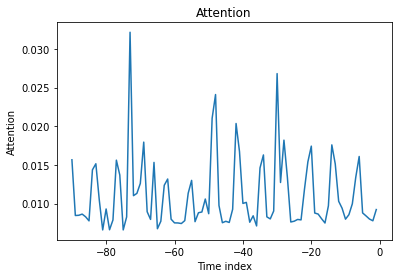

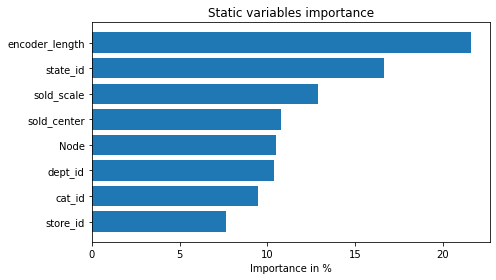

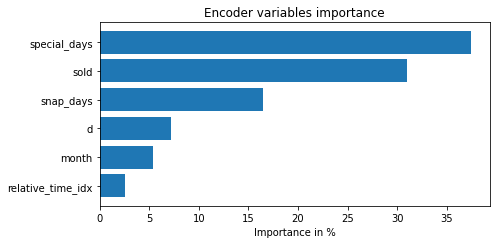

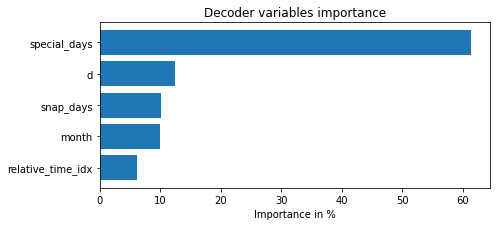

In [7]:
fig_list = []

for dr in dirs[-2:-1]:
    path = glob(dr+'checkpoints/*.ckpt')
    load_tft = TemporalFusionTransformer.load_from_checkpoint(path[0])
    pred, x = load_tft.predict(test_dataset, mode="raw", return_x=True)
    interpretation = load_tft.interpret_output(pred, reduction="sum")
    figures = load_tft.plot_interpretation(interpretation)
    fig_list.append(figures)

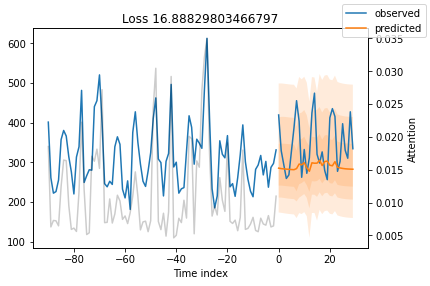

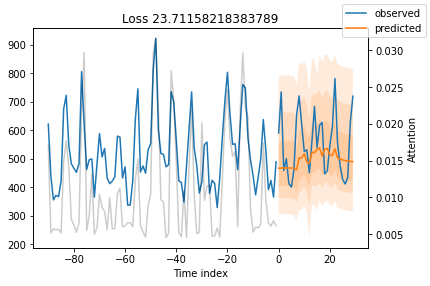

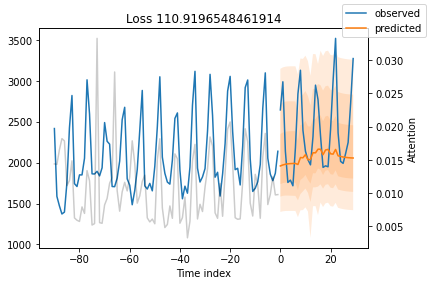

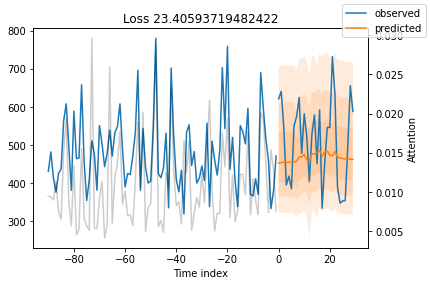

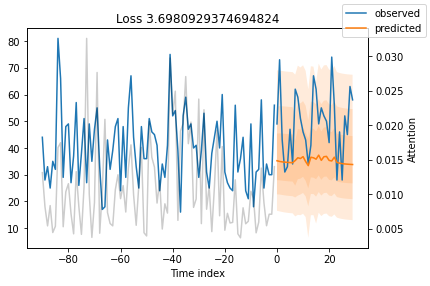

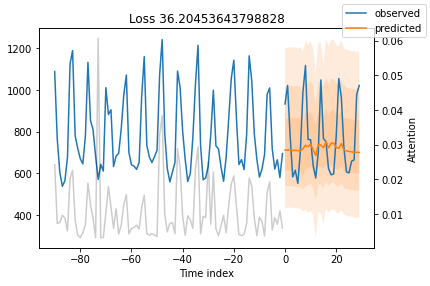

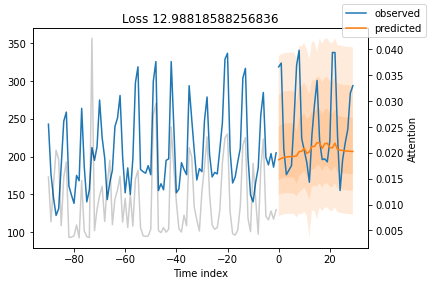

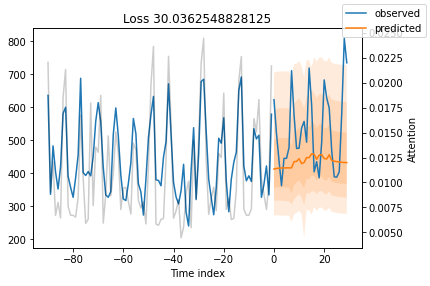

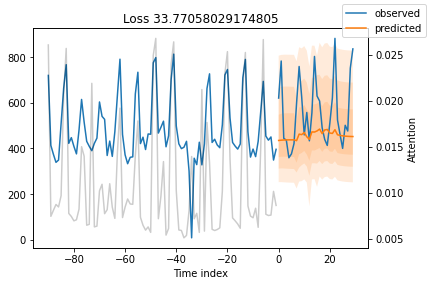

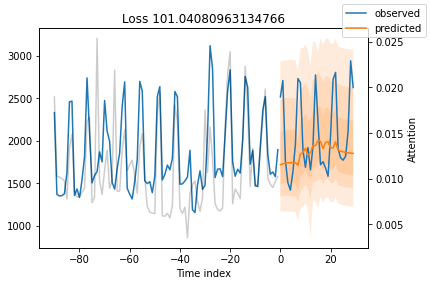

In [8]:
for idx in range(10):
    load_tft.plot_prediction(x, pred, idx=idx, add_loss_to_title=True);

In [10]:
pred.keys()

dict_keys(['prediction', 'attention', 'static_variables', 'encoder_variables', 'decoder_variables', 'decoder_lengths', 'encoder_lengths'])

In [14]:
pred['encoder_variables'].shape

torch.Size([70, 90, 1, 6])

In [16]:
pred['decoder_variables'].shape

torch.Size([70, 30, 1, 5])

In [15]:
pred['static_variables'].shape

torch.Size([70, 1, 8])

In [18]:
pred['attention'].shape

torch.Size([70, 30, 4, 120])